# Herron Topic 5 - Practice - Sec 03

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from scipy.stats import norm # new addition for Monte Carlo methods
import warnings # to suppress the pandas_datareader warning
import yfinance as yf

In [2]:
%precision 2
pd.options.display.float_format = '{:.2f}'.format
# %config InlineBackend.figure_format = 'retina'

## Announcements

1. Programming assessment and MSFQ assessment will be *in class and in person on Tuesday, 4/15, in your scheduled section*
    1. Details here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2765433>
    2. And here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2727917>
2. Our plan for the rest of the semester
    1. Friday, 4/11, Project 2 solution, envelopes solution, and Project 3 group work
    2. Tuesday, 4/15, programming and MSFQ assessment *in class and in person, in your scheduled section*
    3. Friday, 4/18, Project 3 group work
    4. Tuesday, 4/22, Project 3 group work
    5. Wednesday, 4/23, Project 3 is due by 11:59 PM
    6. Friday, 4/25, office hours during regular class time
3. Please complete TRACE! I value and use your feedback.
    1. Details here: <https://northeastern.instructure.com/courses/207607/discussion_topics/2753925>

## Five-Minute Recap

In finance, we use two main simulation methods: Monte Carlo and bootstrap.
Both help analyze financial data, but work differently.

**Monte Carlo** methods create many possible paths of financial variables (e.g., stock prices, interest rates) based on theoretical probability distributions:

- Generates synthetic data from assumed models
- Creates data that may not exist in historical records
- Based on random sampling from probability distributions
- Think `np.random.uniform()` or `np.random.normal()` to create new random variables

**Bootstrap** methods take a different approach:

- Resamples from actual historical data (with or without replacement)
- Makes minimal assumptions about distributions
- Maintains statistical properties of original data
- Think `.sample()` to resample past obervations

##  Practice

### Estimate $\pi$ by simulating darts thrown at a dart board

*Hints:*
Select random $x$s and $y$s such that $-r \leq x \leq +r$ and $-r \leq x \leq +r$.
Darts are on the board if $x^2 + y^2 \leq r^2$.
The area of the circlular board is $\pi r^2$, and the area of square around the board is $(2r)^2 = 4r^2$.
The fraction $f$ of darts on the board is the same as the ratio of circle area to square area, so $f = \frac{\pi r^2}{4 r^2}$.

First we throw darts at the board.
Darts with $x^2 + y^2 \leq r^2$ are on the board.

In [3]:
def throw_darts(n=1_000, r=1, seed=42):
    np.random.seed(seed)
    return (
        pd.DataFrame(
            data=np.random.uniform(low=-r, high=r, size=2*n).reshape(n, 2),
            columns=['X', 'Y']
        )
        .assign(On_Board=lambda x: x['X']**2 + x['Y']**2 <= r**2)
    )

In [4]:
throw_darts()

,X,Y,On_Board
0,-0.25,0.90,True
1,0.46,0.20,True
2,-0.69,-0.69,True
3,-0.88,0.73,False
4,0.20,0.42,True
...,...,...,...
995,0.53,-0.68,True
996,0.22,-0.73,True
997,0.50,0.31,True
998,0.91,-0.86,False


In [5]:
4 * throw_darts(n=1_000_000)['On_Board'].mean()

3.14

Next, we visualize these darts with a scatter plot.
Seaborn's `scatterplot()` helps color darts by location (i.e., on or off board).
The `.pipe()` method lets us send the output of the `.assign()` method to `sns.scatterplot()` without assigning a temporary data frame.

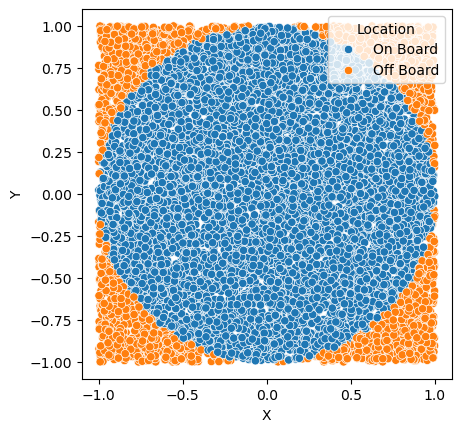

In [6]:
(
    throw_darts(n=10_000)
    .assign(Location=lambda x: np.where(x['On_Board'], 'On Board', 'Off Board'))
    .pipe(
        sns.scatterplot,
        x='X',
        y='Y',
        hue='Location'
    )
)
plt.gca().set_aspect('equal')

Finally, we use the hint above to estimate $\pi$.
The hint above says $f = \frac{\pi r^2}{4 r^2}$, where $f$ is the fraction of darts on the board.
Therefore, $\pi \approx \frac{4fr^2}{r^2} = 4f$.
We increase the precision of our $\pi$ estimate by increasing the number of simulated darts $n$.

In [7]:
for n in 10**np.arange(7):
    print(f'With {n:>9,.0f} dart throws, our estimate of pi is: {4 * throw_darts(n=n)['On_Board'].mean():,.4f}')

With         1 dart throws, our estimate of pi is: 4.0000
With        10 dart throws, our estimate of pi is: 3.2000
With       100 dart throws, our estimate of pi is: 3.0400
With     1,000 dart throws, our estimate of pi is: 3.1040
With    10,000 dart throws, our estimate of pi is: 3.1544
With   100,000 dart throws, our estimate of pi is: 3.1468
With 1,000,000 dart throws, our estimate of pi is: 3.1420


### Simulate your wealth $W_T$ by randomly sampling market returns

Use monthly market returns from the French Data Library.
Only invest one cash flow $W_0$, and plot the distribution of $W_T$.

First, we download data from the French Data Library.
We convert these returns from percent to decimal to simplify compounding.

In [8]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    ff3 = (
        pdr.DataReader(
            name='F-F_Research_Data_Factors',
            data_source='famafrench',
            start='1900'
        )
        [0]
        .assign(Mkt=lambda x: x['Mkt-RF'] + x['RF'])
        .div(100)
    )

1. Use `.sample()` to simulate one alternate history
2. Add `pd.concat()` and a list comprehension to simulate `N` alternate histories
3. Examine/plot the distributoin of `W_T`

In [9]:
ff3['Mkt'].sample(n=5, random_state=42, ignore_index=True)

0    0.03
1    0.03
2    0.04
3   -0.11
4   -0.02
Name: Mkt, dtype: float64

We can combine many samples of many months with a list comprehension and `pd.concat()`.

In [10]:
W_0 = 50_000 
T = 30 * 12
N = 1_000

r_t = pd.concat(
    objs=[ff3['Mkt'].sample(n=T, random_state=i, ignore_index=True) for i in range(N)],
    keys=range(N),
    names=['Simulation'],
    axis=1
)

In [11]:
r_t.iloc[:5, :5]

Simulation,0,1,2,3,4
0,0.04,0.01,0.02,0.03,0.08
1,-0.03,-0.02,0.04,0.01,-0.02
2,-0.00,0.06,0.06,0.02,0.00
3,-0.05,-0.02,0.04,0.02,-0.05
4,0.02,-0.04,-0.01,-0.02,0.00


In [12]:
W_T = W_0 * r_t.add(1).prod()

We visualize terminal wealth $W_T$ with a cumulative distribution plot.

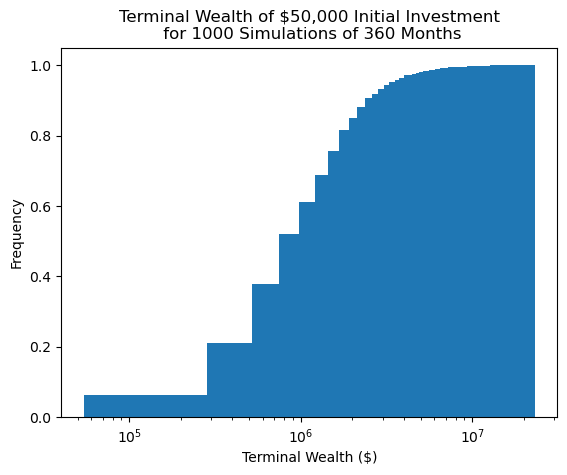

In [13]:
W_T.plot(kind='hist', cumulative=True, density=True, bins=100, logx=True)
plt.xlabel('Terminal Wealth ($)')
plt.title(f'Terminal Wealth of ${W_0:,.0f} Initial Investment\n for {N} Simulations of {T} Months')
plt.show()

The plot above may be difficult to read and interpret because $W_T$ has large outliers.
We can use a `for` to calculate several levels of confidence.

In [14]:
for i in [0.01, 0.02, 0.03, 0.04, 0.05]:
    print(f'In {100-100*i:,.0f}% of outcomes, an initial investment of ${W_0:,.0f} for {T} months has a terminal wealth greater than ${W_T.quantile(i):,.0f}')

In 99% of outcomes, an initial investment of $50,000 for 360 months has a terminal wealth greater than $146,041
In 98% of outcomes, an initial investment of $50,000 for 360 months has a terminal wealth greater than $195,993
In 97% of outcomes, an initial investment of $50,000 for 360 months has a terminal wealth greater than $215,765
In 96% of outcomes, an initial investment of $50,000 for 360 months has a terminal wealth greater than $240,818
In 95% of outcomes, an initial investment of $50,000 for 360 months has a terminal wealth greater than $271,537


### Repeat the exercise above but add end-of-month investments $C_t$

We can use the same data frame `r_t` of simulated market returns.
However, need to consider end-of-month investments of `C_t`.
The easiest approach is to write a `for` that starts with `W_last = W_0`, then each month updates `W_last = W_last * (1 + r) + C_t`.
Finally, it `pd.concat()`s these monthly values of `W_last` into a data frame of monthly wealths `W_t`.

In [15]:
C_t = 1_000
W_last = W_0
W_t = []

for i, r in r_t.iterrows():
    W_last = (1 + r) * W_last + C_t
    W_t.append(W_last)

W_t = pd.concat(objs=W_t, axis=1, keys=r_t.index).transpose()

In [16]:
W_t.iloc[:5, :5]

Simulation,0,1,2,3,4
0,53190.00,51595.00,51805.00,52455.00,54830.00
1,52860.25,51449.59,54726.97,54178.88,54996.58
2,53743.96,55613.74,58829.98,56051.16,56106.58
3,52051.39,55662.75,62400.85,57919.95,54318.08
4,54087.21,54514.16,62864.21,57645.71,55328.94


In [17]:
W_T = W_t.iloc[-1]

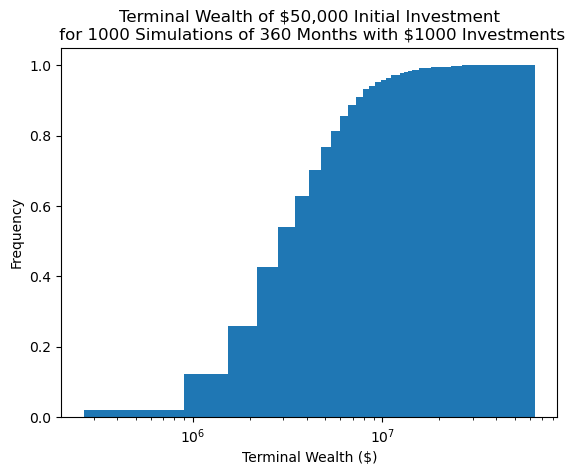

In [18]:
W_T.plot(kind='hist', cumulative=True, density=True, bins=100, logx=True)
plt.xlabel('Terminal Wealth ($)')
plt.title(f'Terminal Wealth of ${W_0:,.0f} Initial Investment\n for {N} Simulations of {T} Months with ${C_t} Investments')
plt.show()

In [19]:
for i in [0.01, 0.02, 0.03, 0.04, 0.05]:
    print(f'In {100-100*i:,.0f}% of outcomes, an initial investment of ${W_0:,.0f} for {T} months with ${C_t} investments has a terminal wealth greater than ${W_T.quantile(i):,.0f}')

In 99% of outcomes, an initial investment of $50,000 for 360 months with $1000 investments has a terminal wealth greater than $786,650
In 98% of outcomes, an initial investment of $50,000 for 360 months with $1000 investments has a terminal wealth greater than $900,482
In 97% of outcomes, an initial investment of $50,000 for 360 months with $1000 investments has a terminal wealth greater than $996,068
In 96% of outcomes, an initial investment of $50,000 for 360 months with $1000 investments has a terminal wealth greater than $1,094,423
In 95% of outcomes, an initial investment of $50,000 for 360 months with $1000 investments has a terminal wealth greater than $1,167,491
